## **breast cancer detection using SVM on ultrasound images**

importing the necessary libraries

In [1]:
import os
import numpy as np
from sklearn import svm, metrics
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io, color, feature
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from skimage import transform
import random
from sklearn.metrics import confusion_matrix

define the function to load dataset from the drive and seprates the image and its class as x and y.

In [2]:
def load_dataset(dataset_path):
    X = []
    y = []
    classes = os.listdir(dataset_path)
    for class_name in classes:
        class_dir = os.path.join(dataset_path, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            X.append(image_path)
            y.append(class_name)
    return X, y

define the function to prepeocess the image in target size [224,224] and converts the image into grayscale image and extracts the hog feature from the image.

In [3]:
def preprocess_image(image_path, target_size=(224, 224)):
    image = io.imread(image_path)
    resized_image = transform.resize(image, target_size)
    grayscale_image = color.rgb2gray(resized_image)
    hog_features = feature.hog(grayscale_image, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    return hog_features

here the dataset loaded and preprocessed using define function and splited into train and test of 0.2 ratio with random state 42.

In [4]:
dataset_path = "/content/drive/MyDrive/MP/train_data"

X, y = load_dataset(dataset_path)
X_processed = [preprocess_image(image_path) for image_path in X]
X_processed = np.array(X_processed)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

this code plot one of the HOG from each class to visualize how it extracted.

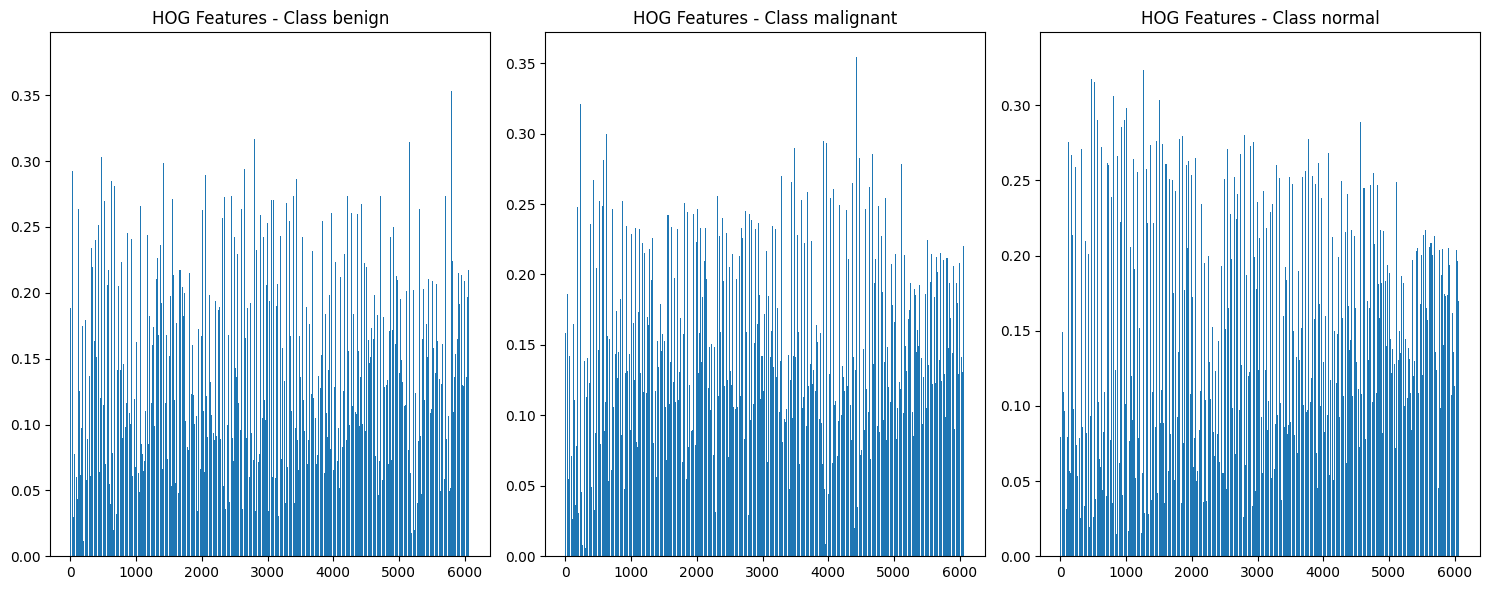

In [5]:
import matplotlib.pyplot as plt
import random

classes = np.unique(y_train)

plt.figure(figsize=(15, 6))
for i, class_label in enumerate(classes, 1):
    class_indices = np.where(y_train == class_label)[0]
    example_index = class_indices[0]
    hog_features = X_train[example_index]
    plt.subplot(1, len(classes), i)
    plt.bar(range(len(hog_features)), hog_features)
    plt.title(f'HOG Features - Class {class_label}')
plt.tight_layout()
plt.show()


this code plot the histogram for the class and its no of samples.

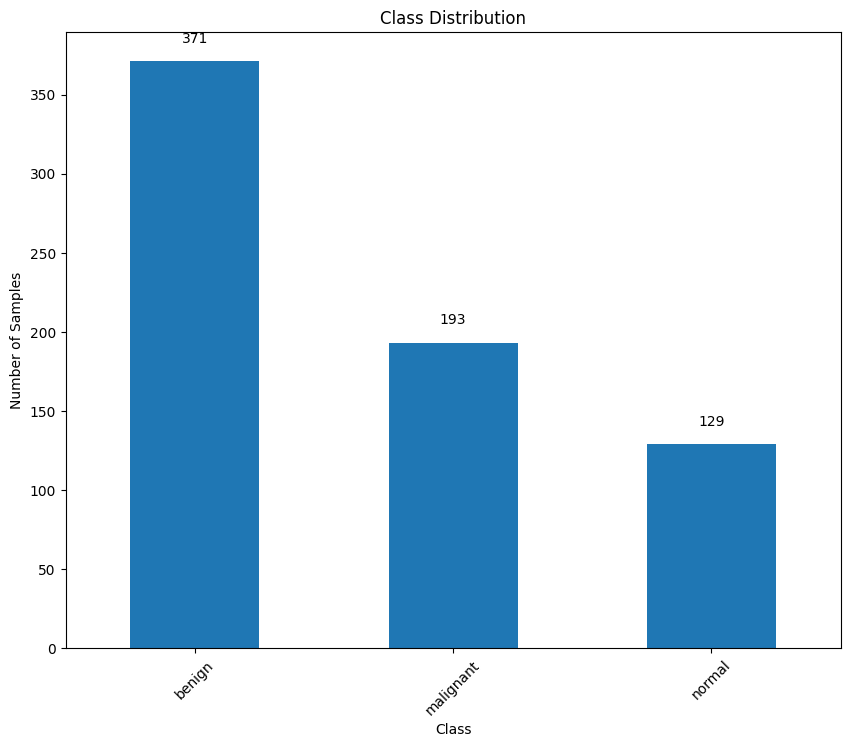

Number of samples: 693
Number of samples per class:
benign       371
malignant    193
normal       129
Name: count, dtype: int64


In [6]:
num_samples = len(X)

class_counts = pd.Series(y).value_counts()

plt.figure(figsize=(10, 8))
class_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

for i, count in enumerate(class_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()
print("Number of samples:", num_samples)
print("Number of samples per class:")
print(class_counts)


this is the number of feature extracted from the each image of each class

In [7]:
import pandas as pd
df = pd.DataFrame(X_processed)
df['label'] = y
grouped = df.groupby('label')

class_stats = grouped.describe()

print("Descriptive Statistics of Features by Class:")
print(class_stats)

Descriptive Statistics of Features by Class:
            0                                                           \
           count      mean       std           min       25%       50%   
label                                                                    
benign     371.0  0.178817  0.086160  8.113585e-09  0.099464  0.198456   
malignant  193.0  0.191978  0.086344  0.000000e+00  0.140859  0.219988   
normal     129.0  0.151220  0.091420  1.271202e-02  0.063748  0.147154   

                                1               ...      6082            \
                75%       max  count      mean  ...       75%       max   
label                                           ...                       
benign     0.253505  0.334741  371.0  0.089255  ...  0.123903  0.255996   
malignant  0.259626  0.312547  193.0  0.110676  ...  0.131799  0.304375   
normal     0.241450  0.314554  129.0  0.081879  ...  0.130654  0.253011   

            6083                                           

classifier is the machine learning model(SVM) which is trained with train dataset and performs prediction with test dataset

In [8]:
classifier = svm.SVC()

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

here is the various sensitive metrics value

In [9]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
f1_score = metrics.f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.6906474820143885
Precision: 0.7560439560439561
Recall: 0.6906474820143885
F1 Score: 0.6578825635808417


this code plots the first 20 output of predicted class and actual class

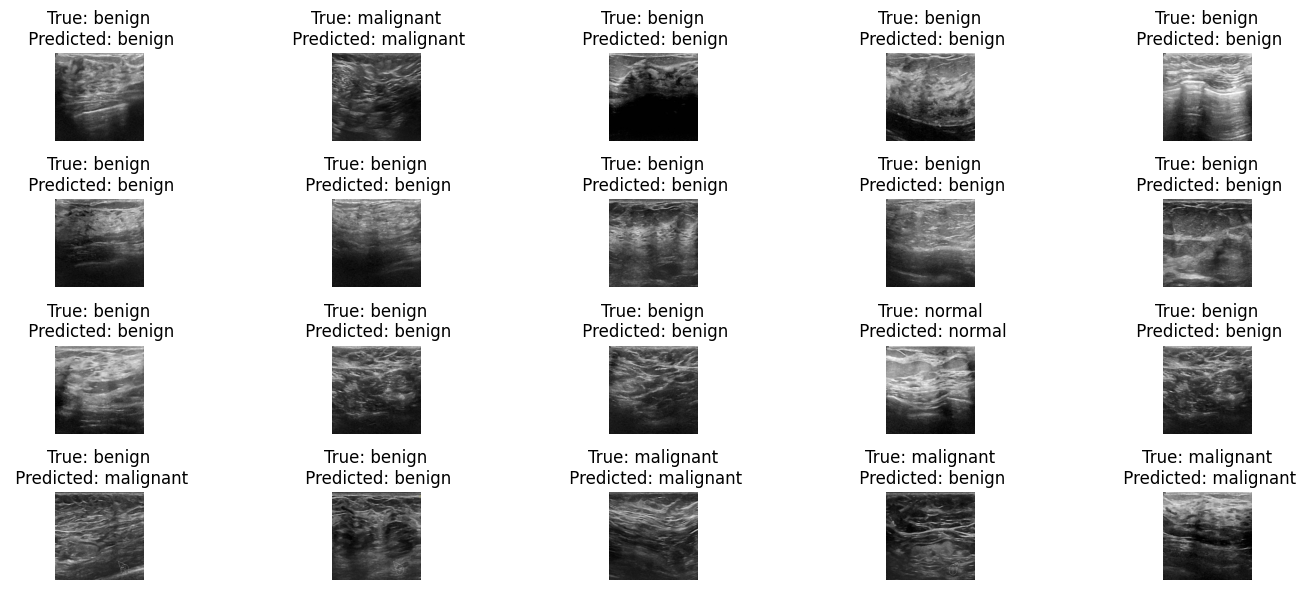

In [10]:
from PIL import Image

plt.figure(figsize=(15, 6))

for i in range(20):
    img = Image.open(X[i])
    img = img.resize((224, 224))

    plt.subplot(4, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {y_test[i]}\n Predicted: {y_pred[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


here is the code for confusion matrix, which it can describe the predicted value and actual value visually.

Confusion Matrix:
[[68  4  0]
 [17 20  0]
 [20  2  8]]


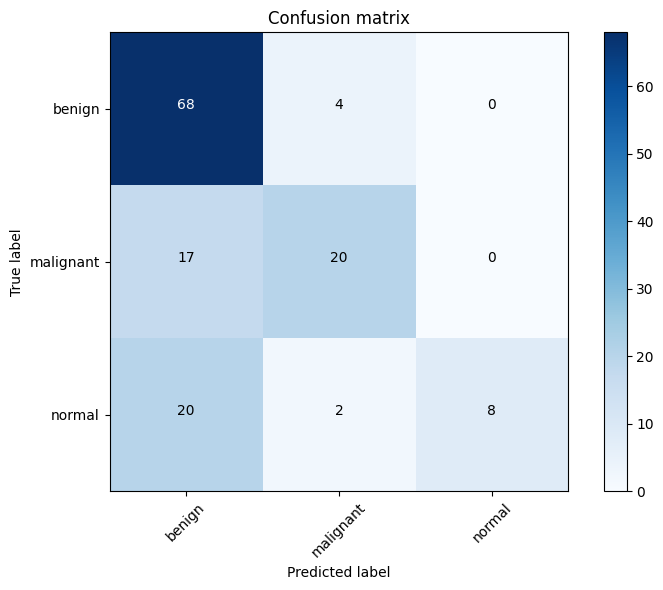

In [11]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

classes = np.unique(y)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

print("Confusion Matrix:")
print(confusion_matrix)

plt.show()

testing our SVM model with a normal image from test dataset

In [ ]:
def predict_new_image(image_path, classifier):

    processed_image = preprocess_image(image_path)


    prediction = classifier.predict([processed_image])

    return prediction[0]

new_image_path = '/content/drive/MyDrive/MP/train_data/normal/normal (1).png'
new_image_prediction = predict_new_image(new_image_path, classifier)
print("Prediction for new image:", new_image_prediction)

Prediction for new image: normal
